In [12]:
from __future__ import print_function

import double_log
def print(*args, **kwargs):
    return double_log.print(*args, **kwargs)

import keras
import pickle
import operator
import numpy as np
import pandas as pd
import tensorflow as tf
import plot_conf_matrix as pcm
from keras import backend as K
from keras.datasets import mnist
from sklearn.metrics import f1_score
from keras.engine.topology import Layer
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Softmax, Reshape

print("===== IMPORTING ||| SCRIPT STARTS ||| LOGGING PURPOSE ======")

===== IMPORTING ||| SCRIPT STARTS ||| LOGGING PURPOSE ======


## Loading Data, Splitting, and Correct Fromating

In [13]:
with open('../../Images/MNIST_noisy/noisy_mnist_50.pickle', 'rb') as fp:
    mnist_noise = pickle.load(fp)

60000 train samples
10000 test samples
30013  elems are true in train
5006  elems are true in test


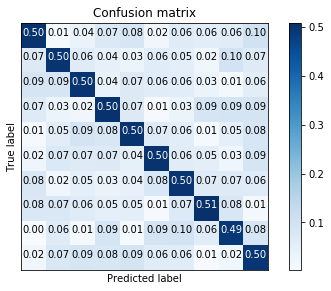

In [14]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# load noisy lables from file, while the iamges and clean labels from built-in function
y_train = mnist_noise['train']
y_test = mnist_noise['test']
(x_train, y_train_clean), (x_test, y_test_clean) = mnist.load_data()

# transform data to what Keras likes
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
cm = confusion_matrix(y_train_clean, y_train)
cm = confusion_matrix(y_train_clean, y_train).astype('float') / cm.sum(axis=1)[:, np.newaxis]
# 10-fold cross validation
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train, y_train))

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(np.sum(y_train == y_train_clean), " elems are true in train")
print(np.sum(y_test == y_test_clean), " elems are true in test")
pcm.plot_confusion_matrix(y_train_clean, y_train, normalize=True)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test_clean = keras.utils.to_categorical(y_test_clean, num_classes)

## SWITCH BETWEEN NOISY AND CLEAN DATA FOR TESTING 
#y_test = y_test_clean

## Define noise layer and models

In [15]:
#returns the confusion matrix (the perfectly known noise distribution) in the NoiseLayer initializer
def confusion_kernel(shape):
    return cm
def identity_kernel(shape):
    return np.eye(10)

#noise layer defined according to Keras functional API
class NoiseLayer(Layer):
    def __init__(self, output_dim, dynamic=True, initializer=identity_kernel, **kwargs):
        self.output_dim = output_dim
        self.dynamic = dynamic
        self.initializer = initializer
        super(NoiseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # weight matrix
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape,
                                      initializer=self.initializer,
                                      trainable=self.dynamic) #change this to false for static weights
        super(NoiseLayer, self).build(input_shape)
    
    #forward pass - vector matrix multiplication of the input and the weights. FIXED for batches
    def call(self, x):
        return tf.nn.softmax(tf.einsum('bn,nm->bn',x, self.kernel))

    def compute_output_shape(self, input_shape):
        return (1, self.output_dim)

In [16]:
#build model without the denoising custom layer
def build_default():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.categorical_accuracy])
    return model

#build model with denoising layer
def build_noisy(trainable, init_func):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # attach noise layer
    model.add(NoiseLayer(num_classes, dynamic=trainable, initializer=init_func))
    model.add(Dropout(0.1))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.categorical_accuracy])
    return model

## Run default model 5 times with cross validation

In [17]:
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
def_model = build_default()
results_def = []
for h in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Default - Fold ",j," - Training Round ",h," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        def_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = def_model.predict(x_test, verbose=0)

        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        results_def.append(f1)
        #print('F1-score:', f1, "\n===================")
        
print("\nAverage model score: %.3f%% (+/- %.3f%%)" % (np.mean(results_def), np.std(results_def)))
print(results_def, '\n\n')

===Default - Fold  0  - Training Round  0  ======
===Default - Fold  1  - Training Round  0  ======
===Default - Fold  2  - Training Round  0  ======
===Default - Fold  3  - Training Round  0  ======
===Default - Fold  4  - Training Round  0  ======
===Default - Fold  0  - Training Round  1  ======
===Default - Fold  1  - Training Round  1  ======
===Default - Fold  2  - Training Round  1  ======
===Default - Fold  3  - Training Round  1  ======
===Default - Fold  4  - Training Round  1  ======
===Default - Fold  0  - Training Round  2  ======
===Default - Fold  1  - Training Round  2  ======
===Default - Fold  2  - Training Round  2  ======
===Default - Fold  3  - Training Round  2  ======
===Default - Fold  4  - Training Round  2  ======
===Default - Fold  0  - Training Round  3  ======
===Default - Fold  1  - Training Round  3  ======
===Default - Fold  2  - Training Round  3  ======
===Default - Fold  3  - Training Round  3  ======
===Default - Fold  4  - Training Round  3  ======


## Run dynamic noise model 5 times with cross validation

In [18]:
# DO I NEED THIS? K.set_learning_phase(1)
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
dyn_model = build_noisy(True, identity_kernel)
results_noise_dyn = []
results_noise_dyn_int = []
for h in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Dynamic - Fold ",j," - Training Round ",h," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        dyn_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = dyn_model.predict(x_test, verbose=0)

        #the whole system's output
        pred = dyn_model.predict(x_test, verbose=0)   
        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        #remove the noise layers to reveal what the base model learnt
        dyn_model2 = Model(dyn_model.input, dyn_model.layers[-2].output)
        pred2 = dyn_model2.predict(x_test, verbose=0, batch_size=10)
        f12 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred2.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        results_noise_dyn.append(f12)
        results_noise_dyn_int.append(f1)
        #print('F1-score:', f12, "Intermediary score: ",f1)
        #print(pd.DataFrame(dyn_model.layers[-2].get_weights()[0]),"\n===================")
        
print("\nAverage score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn), np.std(results_noise_dyn)))
print("\nAverage Intermediary model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn_int), np.std(results_noise_dyn_int)))
print(results_noise_dyn, '\n\n')
 

===Dynamic - Fold  0  - Training Round  0  ======
===Dynamic - Fold  1  - Training Round  0  ======
===Dynamic - Fold  2  - Training Round  0  ======
===Dynamic - Fold  3  - Training Round  0  ======
===Dynamic - Fold  4  - Training Round  0  ======
===Dynamic - Fold  0  - Training Round  1  ======
===Dynamic - Fold  1  - Training Round  1  ======
===Dynamic - Fold  2  - Training Round  1  ======
===Dynamic - Fold  3  - Training Round  1  ======
===Dynamic - Fold  4  - Training Round  1  ======
===Dynamic - Fold  0  - Training Round  2  ======
===Dynamic - Fold  1  - Training Round  2  ======
===Dynamic - Fold  2  - Training Round  2  ======
===Dynamic - Fold  3  - Training Round  2  ======
===Dynamic - Fold  4  - Training Round  2  ======
===Dynamic - Fold  0  - Training Round  3  ======
===Dynamic - Fold  1  - Training Round  3  ======
===Dynamic - Fold  2  - Training Round  3  ======
===Dynamic - Fold  3  - Training Round  3  ======
===Dynamic - Fold  4  - Training Round  3  ======


## Run static noise model 5 times with cross validation

In [19]:
# DO I NEED THIS? K.set_learning_phase(1)
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
sta_model = build_noisy(False, confusion_kernel)
results_noise_sta = []
results_noise_sta_int = []
for h in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Static - Fold ",j," - Training Round ",h," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        sta_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = sta_model.predict(x_test, verbose=0)

        #the whole system's output
        pred = sta_model.predict(x_test, verbose=0)   
        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        #remove the noise layers to reveal what the base model learnt
        sta_model2 = Model(sta_model.input, sta_model.layers[-2].output)
        pred2 = sta_model2.predict(x_test, verbose=0, batch_size=10)
        f12 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred2.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        results_noise_sta.append(f12)
        results_noise_sta_int.append(f1)
        #print('F1-score:', f12, "Intermediary score: ",f1)
        #print(pd.DataFrame(model.layers[-2].get_weights()[0]),"\n===================")
        
print("\nAverage score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta), np.std(results_noise_sta)))
print("\nAverage Intermediary model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta_int), np.std(results_noise_sta_int)))
print(results_noise_sta, '\n\n')

===Static - Fold  0  - Training Round  0  ======
===Static - Fold  1  - Training Round  0  ======
===Static - Fold  2  - Training Round  0  ======
===Static - Fold  3  - Training Round  0  ======
===Static - Fold  4  - Training Round  0  ======
===Static - Fold  0  - Training Round  1  ======
===Static - Fold  1  - Training Round  1  ======
===Static - Fold  2  - Training Round  1  ======
===Static - Fold  3  - Training Round  1  ======
===Static - Fold  4  - Training Round  1  ======
===Static - Fold  0  - Training Round  2  ======
===Static - Fold  1  - Training Round  2  ======
===Static - Fold  2  - Training Round  2  ======
===Static - Fold  3  - Training Round  2  ======
===Static - Fold  4  - Training Round  2  ======
===Static - Fold  0  - Training Round  3  ======
===Static - Fold  1  - Training Round  3  ======
===Static - Fold  2  - Training Round  3  ======
===Static - Fold  3  - Training Round  3  ======
===Static - Fold  4  - Training Round  3  ======
===Static - Fold  0 

## Score for default model

In [20]:
print("\nAverage model score: %.3f%% (+/- %.3f%%)" % (np.mean(results_def), np.std(results_def)))
print(results_def, '\n\n')


Average model score: 0.846% (+/- 0.087%)
[0.9803, 0.967, 0.9453, 0.937, 0.897, 0.8939, 0.9014, 0.8989, 0.8984, 0.8875, 0.8929, 0.8561, 0.8488, 0.8322, 0.8697, 0.8713, 0.842, 0.7297, 0.7511, 0.7569, 0.6048, 0.8173, 0.8039000000000001, 0.7532, 0.7079000000000001] 




## Score for Noise model with dynamically updated weight matrix

In [21]:
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn), np.std(results_noise_dyn)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn_int), np.std(results_noise_dyn_int)))
print(results_noise_dyn, '\n\n')


Average Intermediary score: 0.91% (+/- 0.05%)

Average model score: 0.91% (+/- 0.05%)
[0.9804, 0.9796, 0.9758, 0.9756, 0.9683, 0.9662, 0.9596, 0.9479, 0.9459000000000001, 0.9281000000000001, 0.9229, 0.9139, 0.9078999999999999, 0.9007, 0.8845, 0.8851, 0.8738, 0.8785, 0.8760999999999999, 0.8504, 0.8379, 0.8737, 0.8521, 0.8574, 0.8257] 




## Score for model with static weight matrix

In [22]:
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta), np.std(results_noise_sta)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta_int), np.std(results_noise_sta_int)))
print(results_noise_sta, '\n\n')


Average Intermediary score: 0.98% (+/- 0.00%)

Average model score: 0.98% (+/- 0.00%)
[0.9773000000000001, 0.9809, 0.9835, 0.9843, 0.9855, 0.9841, 0.9844, 0.9844, 0.9854, 0.9846, 0.983, 0.9845, 0.9848999999999999, 0.9853, 0.9839, 0.9843, 0.9851, 0.9828, 0.9819, 0.9834, 0.9816, 0.9819, 0.9833, 0.9829, 0.9828] 


